In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import sqrtm
from scipy.sparse import csgraph
from scipy import linalg
import itertools

In [2]:
N_TRIAL = 30000
N_ARMS = 100 #N_ARMS -> number of clients
N_FEATURE = 3
M = 29

In [3]:
# X --> TBD now using x_{it} = [1,t,t^2] for all client i
Y_1 = np.genfromtxt('Y(noise0.1).csv',delimiter=',')
W = np.genfromtxt('W(noise0.1).csv',delimiter=',')
Beta = np.genfromtxt('Beta(noise0.1).csv',delimiter=',')

In [4]:
oracle_lst = []
true_choice = []
new_y = -1 * Y_1 + 30 #
for t in np.arange(N_TRIAL):
  # Find indices of M highest arms
  all_reward_t = [new_y.T[t, arm] for arm in np.arange(N_ARMS)]
  chosen_arms = np.array(all_reward_t).argsort()[-M:][::-1]
  # Sum of M highest rewards
  oracle_payoff_t = np.sum([new_y.T[t, choice] for choice in chosen_arms])
  # Append to the list
  oracle_lst.append(oracle_payoff_t)
  true_choice.append(chosen_arms)
oracle_case1 = np.array(oracle_lst)

In [5]:
# Create X_i = [1, t, t^2]
X_1_lst = []
for T in np.arange(N_TRIAL):
  X_1t_lst = []
  for arm in np.arange(N_ARMS):
    temp = []
    temp.append(1)
    temp.append(0.001*(T+1))
    temp.append((0.001*(T+1))**2)
    X_1t_lst.append(np.array(temp))
  X_1_lst.append(np.array(X_1t_lst))
X_1 = np.array(X_1_lst)

In [6]:
def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)

def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x['r_payoff'], oracle=oracle), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

In [7]:
# convert to a sparse matrix -> convert to a long sparse vector with flatten()
def X_to_X_m(X, t, arm_choice, n_arms, n_feature): 
  X_m = np.copy(X[t])
  for arm in np.arange(n_arms): # N x p
    if arm not in arm_choice:
      X_m[arm] = np.zeros(shape=n_feature)
  return X_m

In [8]:
#upload/download trigger
#UPLOAD
def upload(gammaU, IDclient, A_loc, A_up_buff): #, eta, n_clients, n_feature
    numerator = linalg.det(A_loc[IDclient])
    denominator = linalg.det(A_loc[IDclient] - A_up_buff[IDclient])
    if denominator == 0:
        return True
    else:
        check = numerator/denominator
        return check > gammaU

#DOWNLOAD
def download(gammaD, IDclient, A_gob, A_down_buff): #, eta, n_clients, n_feature
    numerator = linalg.det(A_gob)
    denominator = linalg.det(A_gob - A_down_buff[IDclient]) #+ eta * np.identity(n=n_feature * n_clients)
    if denominator == 0:
        return True
    else:
        check = numerator/denominator
        return check > gammaD

In [9]:
def Fed_LinUCB(alpha, eta, X, Y, m, oracle, gammaU, gammaD):
    n_trial, n_clients, n_feature = X.shape
    
    # 1.1.output object
    r_payoff = np.empty(n_trial)
    c_payoff = np.empty(n_trial)
    cum_regret = np.empty(n_trial)
    client_choice = np.empty(shape=(n_trial, m), dtype=int)
    p = np.empty(shape=(n_trial, n_clients))
    totalCommCost = 0
    cum_totalCommCost = np.empty(n_trial)
    
    # 1.2. local statistics
    A_loc = np.array([eta * np.identity(n=n_feature * n_clients) for _ in np.arange(n_clients)]) #np.zeros((n_feature * n_clients, n_feature * n_clients))
    A_up_buff = np.array([np.zeros((n_feature * n_clients, n_feature * n_clients)) for _ in np.arange(n_clients)]) #np.zeros((n_feature * n_clients, n_feature * n_clients))
    b_loc = np.array([np.zeros(shape=n_feature * n_clients)  for _ in np.arange(n_clients)])
    b_up_buff = np.array([np.zeros(shape=n_feature * n_clients)  for _ in np.arange(n_clients)])
    theta_loc = np.empty(shape=(n_trial, n_clients, n_feature* n_clients))
    
    # 1.3 Global statistics
    A_gob = eta * np.identity(n=n_feature * n_clients) #np.zeros((n_feature * n_clients, n_feature * n_clients))
    A_down_buff = np.array([np.zeros((n_feature * n_clients, n_feature * n_clients)) for _ in np.arange(n_clients)])  #np.zeros((n_feature * n_clients, n_feature * n_clients))
    b_gob = np.zeros(shape=n_feature * n_clients)
    b_down_buff = np.array([np.zeros(shape=n_feature * n_clients)  for _ in np.arange(n_clients)])
    
    # 2. Algorithm
    for t in np.arange(n_trial):
        # Compute estimates prediction (p) for all clients
        for a in np.arange(n_clients):
            inv_A = np.linalg.inv(A_loc[a])
            theta_loc[t, a] = inv_A.dot(b_loc[a])
            X_1_tr = (X_to_X_m(X, t, [a], n_clients, n_feature)).flatten()
            p[t, a] = theta_loc[t, a].dot(X_1_tr) + alpha * np.sqrt(np.dot(np.dot(X_1_tr, inv_A), X_1_tr))
            
        # The central server chooses m best clients
        idx = np.argpartition(p[t], -m)[-m:]
        chosen_clients = idx[np.argsort(-(p[t])[idx])]
        for i in np.arange(m):
          client_choice[t][i] = chosen_clients[i]
        
        # Update local statistics based on following conditions
        for chosen_client in client_choice[t]:
            
            # client local update
            X_1_tr_chosen = (X_to_X_m(X, t, [chosen_client], n_clients, n_feature)).flatten()
            A_loc[chosen_client] = A_loc[chosen_client] + np.outer(X_1_tr_chosen, X_1_tr_chosen)
            b_loc[chosen_client] = b_loc[chosen_client] + Y[t, chosen_client] * X_1_tr_chosen
            A_up_buff[chosen_client] = A_up_buff[chosen_client] + np.outer(X_1_tr_chosen, X_1_tr_chosen)
            b_up_buff[chosen_client] = b_up_buff[chosen_client] + Y[t, chosen_client] * X_1_tr_chosen
            
            # check upload triggering event
            if upload(gammaU, chosen_client, A_loc, A_up_buff): #, eta, n_clients, n_feature
                totalCommCost += 1
                
                # update server's statistics
                A_gob += A_up_buff[chosen_client]
                b_gob += b_up_buff[chosen_client]
                
                # update server's download buffer for other clients
                for clientID in np.arange(n_clients):
                    if clientID != chosen_client:
                        A_down_buff[clientID] += A_up_buff[chosen_client]
                        b_down_buff[clientID] += b_up_buff[chosen_client]
                        
                # clear client's upload buffer
                A_up_buff[chosen_client] = np.zeros((n_feature * n_clients, n_feature * n_clients))
                b_up_buff[chosen_client] = np.zeros(shape=n_feature * n_clients)

                # check download triggering event for all clients
                for cli in np.arange(n_clients):
                    if download(gammaD, cli, A_gob, A_down_buff): #, eta, n_clients, n_feature
                        totalCommCost += 1
                        
                        # update client's local statistics, and clear server's download buffer
                        A_loc[cli] += A_down_buff[cli]
                        b_loc[cli] += b_down_buff[cli]
                        
                        # clear cserver's download buffer
                        A_down_buff[cli] = np.zeros((n_feature * n_clients, n_feature * n_clients))
                        b_down_buff[cli] = np.zeros(shape=n_feature * n_clients)
            
            #else: if do not pass the upload, then the statistics are still the same in local
               
        #else: for other clients not selected at round t, the statistics are still the same in local      
        
        # Cumulative regret
        r_payoff[t] = np.sum([Y[t, choice] for choice in client_choice[t]])      
        cum_regret[t] = np.sum(oracle[0:t+1] - r_payoff[0:t+1])
        cum_totalCommCost[t] = totalCommCost
        if (t+1) % 5000 == 0:
            print('TRIAL:',t,'DONE', '| cum_regret:', cum_regret[t])
            print('Total Communication cost:', totalCommCost)
    
    return dict(A_gob=A_gob, b_gob=b_gob, theta_loc=theta_loc, p=p, client_choice = client_choice, r_payoff=r_payoff, totalCommCost=totalCommCost, cum_totalCommCost=cum_totalCommCost)

In [10]:
# Run LinUCB
alpha_to_test = [3.25]
results_dict = {alpha: Fed_LinUCB(alpha = alpha, eta = 0.3, X=X_1, Y=(-1 * Y_1 + 30).T, m=M, oracle=oracle_case1, gammaU=1, gammaD=1)\
                for alpha in alpha_to_test}

TRIAL: 4999 DONE | cum_regret: 5891.735347919745
Total Communication cost: 3714000
TRIAL: 9999 DONE | cum_regret: 7689.448995152369
Total Communication cost: 3714000
TRIAL: 14999 DONE | cum_regret: 8551.204069662588
Total Communication cost: 3714000
TRIAL: 19999 DONE | cum_regret: 9143.649610180611
Total Communication cost: 3714000
TRIAL: 24999 DONE | cum_regret: 9456.502041471595
Total Communication cost: 3714000
TRIAL: 29999 DONE | cum_regret: 9704.081627864914
Total Communication cost: 3714000


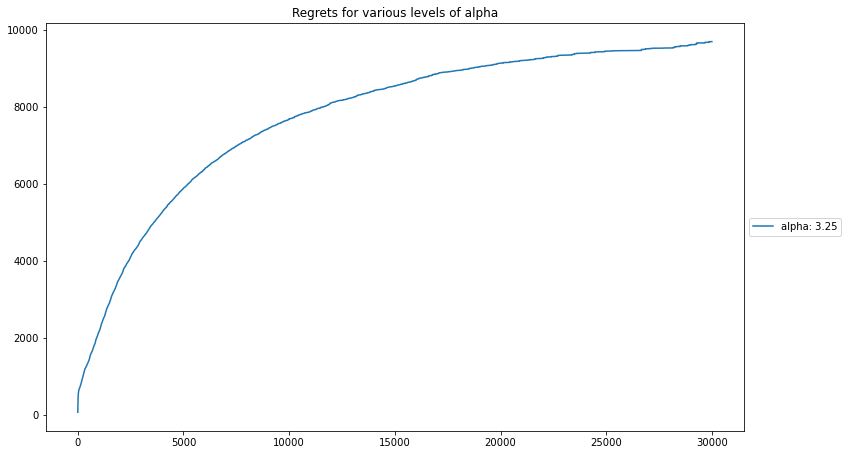

In [11]:
# Plot regrets
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracle_case1)
# plt.legend()
# plt.legend(prop={'size': 12}, loc='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Regrets for various levels of alpha")
plt.show()

In [12]:
# export regret data
# test_lst = [make_regret(payoff=x['r_payoff'], oracle=oracle_case1) for (alpha, x) in results_dict.items()]
# df = pd.DataFrame(test_lst[0]) #index 4 is for alpha = 10
# df.to_csv('C2_GOBLin_regret_66_new.csv', header=False)
# df.to_csv('fed_C1_LinUCB 33.csv', header=False) #(big)

# test_lst = [x['cum_totalCommCost'] for (alpha, x) in results_dict.items()]
# df = pd.DataFrame(test_lst[0]) #index 4 is for alpha = 10 
# df.to_csv('C1_fedLinUCB_CommCost_29.csv', header=False)

In [13]:
# 0 = 0, 1 = 1, 2 = 2.5, 3 = 5, 4 = 10, 5 = 20
# export reward
# test_lst = [x['c_payoff'] for (alpha, x) in results_dict.items()]
# df = pd.DataFrame(test_lst[2]) #index 4 is for alpha = 10 
# df.to_csv('C2_GOBLin_reward(big+0.9).csv', header=False)

In [14]:
# fixed # alpha = 3.25/ gammaU = gammaD = 1
# TRIAL: 4999 DONE | cum_regret: 5891.735347919745
# Total Communication cost: 3714000
# TRIAL: 9999 DONE | cum_regret: 7689.448995152369
# Total Communication cost: 3714000
# TRIAL: 14999 DONE | cum_regret: 8551.204069662588
# Total Communication cost: 3714000
# TRIAL: 19999 DONE | cum_regret: 9143.649610180611
# Total Communication cost: 3714000
# TRIAL: 24999 DONE | cum_regret: 9456.502041471595
# Total Communication cost: 3714000
# TRIAL: 29999 DONE | cum_regret: 9704.081627864914
# Total Communication cost: 3714000

# fixed # alpha = 3.25/ gammaU = gammaD = 2
# TRIAL: 4999 DONE | cum_regret: 5891.735347919745
# Total Communication cost: 130200
# TRIAL: 9999 DONE | cum_regret: 7689.448995152369
# Total Communication cost: 130200
# TRIAL: 14999 DONE | cum_regret: 8551.204069662588
# Total Communication cost: 130200
# TRIAL: 19999 DONE | cum_regret: 9143.649610180611
# Total Communication cost: 130200
# TRIAL: 24999 DONE | cum_regret: 9456.502041471595
# Total Communication cost: 130200
# TRIAL: 29999 DONE | cum_regret: 9704.081627864914
# Total Communication cost: 130200